Есть гипотеза:
Если мы применим новую модель рекомендаций, то повысим продажи продуктов `deposit_4` и
`insurance`.
Решили проверить данное утверждение через AB-тест, который проводился с 2021-02-24 по 2021-03-
12.
В clients залили клиентов с group_type=’tg’ - у кого новая рекомендательная система; ‘cg’ - у кого
рекомендации оставили без изменений.

Твоя задача:  
Рассчитать результаты ab-теста, сделать репрезентативные визуализации (python, excel, power
bi - любой удобный тебе) + таблички и вывод о том, подтвердилась ли гипотеза + пояснить
вывод.

Данные:  
Таблицы:  
1. сlients – список клиентов:  
• client_id - id клиента  
• group_type – к какой группе относится (tg-целевая, cg-тестовая)  
2. shows – показы продуктов клиентам:  
• calday – дата показа  
• product_id – какой продукт показали  
3. sales – продажи продуктов:  
• calday – дата продажи  
• product_id – какой продукт продали  
4. products – каталог продуктов:  
• id – id продукта  
• product_name – наименование продукта

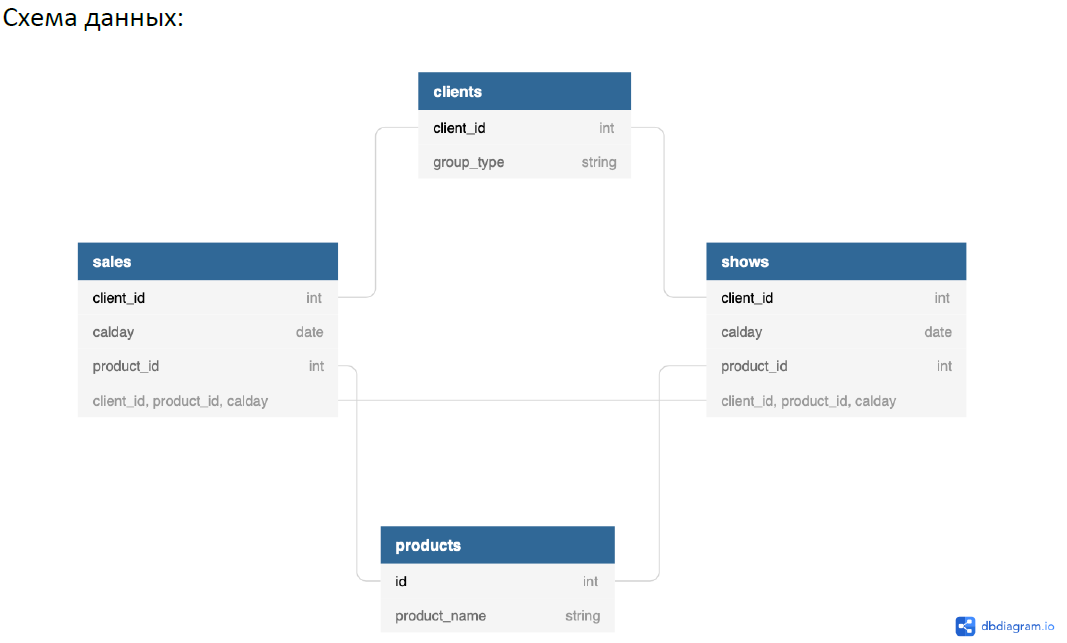

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

# Data

In [2]:
# загружаем все наши данные

clients = pd.read_parquet('clients.parquet')
clients.head()

,client_id,group_type
0,346650,tg
1,731109,tg
2,348929,tg
3,492187,tg
4,1062172,tg


In [3]:
shows = pd.read_parquet('shows.parquet')

# заменили строки, где product_id не проставлен на NaN
shows['product_id'].replace('  ', np.nan, inplace=True)

#удалили эти строки
shows = shows.dropna(subset=['product_id'])

# преобразовали типы для calday - в дату, для product_id - в int
shows['calday'] = pd.to_datetime(shows['calday'])
shows['product_id'] = shows['product_id'].apply(int)
shows.head()

,client_id,calday,product_id
0,163024,2021-02-10,645
1,205317,2021-02-10,987
2,629625,2021-02-10,987
3,655722,2021-02-10,442
4,784840,2021-02-10,987


In [4]:
products = pd.read_parquet('products.parquet')
products.head()

,id,product_name
0,442,loan_10
1,376,loan_15
2,645,insurance
3,987,deposit_4
4,297,deposit_3


In [5]:
sales = pd.read_parquet('sales.parquet')

# заменили строки, где product_id не проставлен на NaN
sales['product_id'].replace('  ', np.nan, inplace=True)

#удалили эти строки
sales = sales.dropna(subset=['product_id'])

# преобразовали типы для calday - в дату, для product_id - в int
sales['product_id'] = sales['product_id'].apply(int)
sales['calday'] = pd.to_datetime(sales['calday'])
sales.head()

,client_id,calday,product_id
0,163024,2021-02-10,645
1,762783,2021-02-10,376
2,741073,2021-02-10,987
3,992292,2021-02-10,987
4,854649,2021-02-10,442


# Анализ данных

In [6]:
#Число клиентов в каждой группе
clients.groupby('group_type').count()

,client_id
group_type,
cg,196682
tg,196346


In [7]:
#Идентификаторы нужных нам продуктов
products[products['product_name'].isin(['deposit_4', 'insurance'])]

,id,product_name
2,645,insurance
3,987,deposit_4


In [8]:
# по условию задачи тест проводился с 2021-02-24 по 2021-03-12
# для продуктов insurance и deposit_4, которые имеют id 645 и 987 соответственно
# оставляем в нашей выборке только эти даты и эти продукты:
shows = shows.query('calday >= "2021-02-24" and calday <="2021-03-12" and product_id in [645,987]')
sales = sales.query('calday >= "2021-02-24" and calday <="2021-03-12" and product_id in [645,987]')

# поскольку мы будем считать конверсию из просмотров в продажи, то нам будет удобно добавить 
# в данные с продажами столбец из единичек
sales['sale_flag'] = 1

In [9]:
# Собираем все данные в один набор - к просмотрам левым джоином присоединяем продажи
# далее inner-джоином присоединяем клиентов
# в итоговом наборе в результате окажутся те клиенты, у которых были показы
# и если кроме показа в этот день была покупка данного товара, то поле sale_flag=1
# если не было продаж, то sale_flag=0
# соответственно, конверсия данного продукта внутри данной группы(tg или cg) 
# есть сумма покупок разделенная на число показов
show_and_sales = pd.merge(
    left=shows,
    right=sales,
    on=['client_id', 'calday', 'product_id'],
    how='left'
)
show_and_sales = pd.merge(left=show_and_sales, right=clients, on='client_id', how='inner')

#где покупок нет ставим 0
show_and_sales.loc[show_and_sales['sale_flag'].isna(), 'sale_flag'] = 0

In [10]:
show_and_sales.head()

,client_id,calday,product_id,sale_flag,group_type
0,452641,2021-02-24,987,0.0,tg
1,289815,2021-02-24,987,0.0,cg
2,1000946,2021-02-24,987,0.0,cg
3,963032,2021-02-24,645,0.0,tg
4,726509,2021-02-24,645,0.0,cg


<AxesSubplot:xlabel='product_id', ylabel='sales_by_day'>

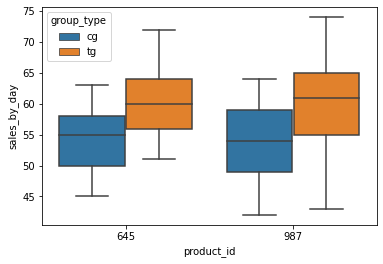

In [11]:
# смотрим, как число покупок в день зависит от группы для наших двух продуктов 
sales_by_day = show_and_sales.groupby(['product_id', 'calday', 'group_type']).aggregate(
    sales_by_day=('sale_flag', 'sum')
).reset_index()
sns.boxplot(x="product_id", y="sales_by_day",hue='group_type', data=sales_by_day)

In [12]:
# посмотрим на конверсию в каждой группе
conversion = show_and_sales.groupby(['product_id', 'group_type']).aggregate(
    sales_in_group=('sale_flag', 'sum'),
    group_size=('group_type', 'count'),
    conversion=('sale_flag', 'mean'), 
).reset_index()

# conversion считается как sales_in_group / group_size
conversion

,product_id,group_type,sales_in_group,group_size,conversion
0,645,cg,916.0,6989,0.131063
1,645,tg,1018.0,7095,0.143481
2,987,cg,917.0,7062,0.129850
3,987,tg,1024.0,7074,0.144755


In [13]:
# считаем для продукта 645
n_old = 6989
p_old = 916 / n_old

n_new = 7095
p_new = 1018 / n_new

diff = p_new - p_old
variance_of_diff = np.sqrt(p_old*(1-p_old)/n_old + p_new*(1-p_new)/n_new)
print(f'''
Доверительный интервал разницы конверсий между новой и старой рек. системами для товара 645: 
[{round(diff - 1.96*variance_of_diff, 4)}, {round(diff + 1.96*variance_of_diff, 4)}]
''')
print(f'Прирост конверсии: {round(100*(p_new - p_old)/p_old, 2)}%')


Доверительный интервал разницы конверсий между новой и старой рек. системами для товара 645: 
[0.0011, 0.0238]

Прирост конверсии: 9.47%


In [14]:
# считаем для продукта 987
n_old = 7062
p_old = 917 / n_old

n_new = 7074
p_new = 1024 / n_new

diff = p_new - p_old
variance_of_diff = np.sqrt(p_old*(1-p_old)/n_old + p_new*(1-p_new)/n_new)
print(f'''
Доверительный интервал разницы конверсий между новой и старой рек. системами для товара 987: 
[{round(diff - 1.96*variance_of_diff, 4)}, {round(diff + 1.96*variance_of_diff, 4)}]
''')
print(f'Прирост конверсии: {round(100*(p_new - p_old)/p_old, 2)}%')


Доверительный интервал разницы конверсий между новой и старой рек. системами для товара 987: 
[0.0036, 0.0262]

Прирост конверсии: 11.48%


# Выводы

* Если посмотреть распределение числа покупок в день между группами tg и cg, то можно увидеть, что для продуктов 645 и 987 существует прирост продаж если показывать пользователю результаты новой рекомендательной системы:

<AxesSubplot:xlabel='product_id', ylabel='sales_by_day'>

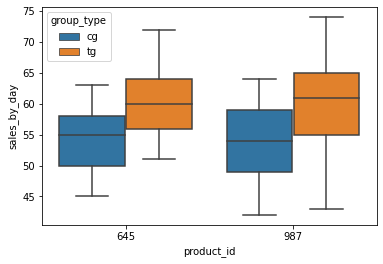

In [15]:
sns.boxplot(x="product_id", y="sales_by_day",hue='group_type', data=sales_by_day)

* Рост конверсии при использовании новой рекомендательной системы для продуктов 645 и 987 составляет 9.47% и 11.48% соответственно:

In [16]:
conversion

,product_id,group_type,sales_in_group,group_size,conversion
0,645,cg,916.0,6989,0.131063
1,645,tg,1018.0,7095,0.143481
2,987,cg,917.0,7062,0.129850
3,987,tg,1024.0,7074,0.144755


* Доверительный 95%-интервал для разницы между старой и новой конверсии составляет: 
    - [0.0011, 0.0238] для продукта 645
    - [0.0036, 0.0262] для продукта 987
* Поскольку оба интервала положительные, то можно сделать статистически значимый вывод о росте конверсии для обоих товаров